# Simple word embeddings with co-occurrences and SVD

The goal of this sheet is to show a simple example of how matrix factorization can be used to embed words.  We will use a small collection of sentences and construct a word-word co-occurrence matrix. For this example, we will treat a word as being in the context of another one if it is within a window of size one of the other one. That is, if it is either before or after the other word.

Note that the code below is not necessarily the most efficient version. It is written in a rather verbose fashion to show the inner workings. Making things more efficient is left as an exercise.

Let us get started.

We will need `numpy` for vector math and also for performing the matrix factorization itself.

In [ ]:
import numpy as np

Our corpus is a tiny collection of three sentences. To make things simpler, let us assume that all the sentences are tokenized.

In [ ]:
text = [["Shakespeare", "wrote", "plays", "."],
        ["John", "read", "them", "."],
        ["John", "wrote", "novels", "."]]

Let us create a collection of all the words that exists in our corpus. We will also add a dummy word `<dummy>` to mark words outside sentences.

In [ ]:
all_words = ["<dummy>"]

for sentence in text:
  for word in sentence:
    all_words.append(word)

all_words = list(set(all_words))
all_words.sort()

num_words = len(all_words)

In [ ]:
print(' '.join(all_words))
print(str(num_words) + " words in vocabulary")

. <dummy> John Shakespeare novels plays read them wrote
9 words in vocabulary


Instead of keeping track of strings, let us map the words in our corpus to indices so that we can use words to lookup vector dimensions. We can do this using a dictionary that maps words to their index.

In [ ]:
word_to_index = dict(zip(all_words, range(num_words)))

In [ ]:
word_to_index['read']

6

Next, let us write a utility function that will pad the dummy word to the beginning and end of a sentence so that if we ask for words before the start or after the end of the sentence, we will get the dummy word instead of an exception.

In [ ]:
def pad_sentence(words, context_size):
  dummy = ["<dummy>"] * context_size

  padded_sentence = []
  padded_sentence.extend(dummy)
  padded_sentence.extend(words)
  padded_sentence.extend(dummy)

  return padded_sentence

In [ ]:
print(pad_sentence(text[0], 2))

['<dummy>', '<dummy>', 'Shakespeare', 'wrote', 'plays', '.', '<dummy>', '<dummy>']


Now, we can write a function that extracts the context (both before and after ) for a word in a sentence. First, it will pad the sentence using the utility above. Then, it will extract as many words as needed from before and after the padded sentence.

In [ ]:
def context(words, word_id, context_size):

  padded_sentence = pad_sentence(words, context_size)

  word_id_in_padded = word_id + context_size

  start = word_id_in_padded - context_size
  end = word_id_in_padded + context_size + 1

  output = padded_sentence[start:word_id_in_padded]
  output.extend(padded_sentence[(word_id_in_padded + 1):end])
  return output

In [ ]:
# The context for the word with index 1 in the first sentence
print(context(text[0], word_id = 1, context_size = 2))

['<dummy>', 'Shakespeare', 'plays', '.']


Now that we know how to extract context words, we can convert them into a vector. The size of the vector is the number of words. For each word in the context, we will find its index using the `word_to_index` we constructed above, and then add to that entry in the vector.

*This code is not necessarily the most efficient way of doing things, but it has the advantage that there is nothing hidden out of view.*

In [ ]:
def context_counts(words, word_id, context_size):

  # This is not the most efficient code, but is written this way to be verbose

  vector = np.zeros(num_words)

  for word in context(words, word_id, context_size):
    index = word_to_index[word]
    vector[index] = vector[index] + 1

  return vector

In [ ]:
context_counts(text[0], 1, 2)

array([1., 1., 0., 1., 0., 1., 0., 0., 0.])

Now, we can build the word-word co-occurrence matrix. This matrix has as many rows and columns as the vocabulary and the $(i,j)^{th}$ entry is the number of times word $j$ occurs in the context of word $i$ in the corpus.

*Once again, this code is not necessarily efficient.*

In [ ]:
# Once again, this code is unnecessarily verbose
def context_matrix(sentences, context_size):
  matrix = np.zeros([num_words, num_words])
  for sentence in sentences:
    sentence_length = len(sentence)
    for id in range(sentence_length):
      word = sentence[id]
      index = word_to_index[word]
      matrix[index] = matrix[index] + context_counts(sentence, id, context_size)
  return matrix

In [ ]:
matrix = context_matrix(text, context_size = 1)

In [ ]:
matrix[0:2]

array([[0., 3., 0., 0., 1., 1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Finally, we can factorize the matrix using its SVD. In other words, we will find three matrices $U$, $\Sigma$ and $V$ such that our co-occurrence matrix $M$ equals $U\Sigma V^T$.

In [ ]:
U, s, V = np.linalg.svd(matrix, full_matrices = False)

Now, we can treat the rows of $U$ as our word embeddings. Let us plot the first two dimensions of $U$ to see where words land.


(-1, 1)

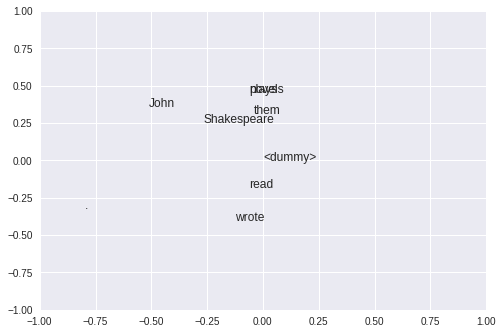

In [ ]:
import matplotlib.pyplot as plt
for word_id in range(num_words):
  plt.text(U[word_id, 0], U[word_id, 1], all_words[word_id])

limits = [-1, 1]
plt.ylim(limits)
plt.xlim(limits)

We don't need to take all dimensions of $U$. Instead, we can fix the dimensionality of the embeddings. Let us use $5$ dimensional vectors and calculate similarities between the words `plays` and `novels` and compare to the similarity between `John` and `plays`. A natural way to calculate similarity is to take the dot product of the vectors.

In [ ]:
dim = 5

plays = U[word_to_index['plays'],0:dim]
novels = U[word_to_index['novels'], 0:dim]
John = U[word_to_index['John'], 0:dim]

print("Similarity(novels, plays): " + str(np.matmul(novels, np.transpose(plays))) )
print("Similarity(John, plays): " + str(np.matmul(John, np.transpose(plays))) )

Similarity(novels, plays): 0.38777575926350916
Similarity(John, plays): 0.08882021060382474


It looks like `plays` is closer to `novels` than it is to `John`. Of course, this is a carefully chosen example and should not be treated as indicating anything meaningful. But with enough data, this method may uncover interesting similarities.